In [1]:
cd ..

/home/tommy/Scrivania/Polimi/Honours Programme/SCFR


In [2]:
from os import listdir, path
import json
import matplotlib.pyplot as plt

from data_structures.cfr_trees import CFRTree
from games.goofspiel import build_goofspiel_tree
from games.kuhn import build_kuhn_tree
from games.leduc import build_leduc_tree
from functools import reduce

In [3]:
def parameters_to_string(par):
    if(par['game'] == 'kuhn'):
        return 'kuhn_' + str(par['players']) + '_' + str(par['rank'])
    if(par['game'] == 'leduc'):
        return 'leduc_' + str(par['players']) + '_' + str(par['suits']) + '_' + str(par['rank'])
    if(par['game'] == 'goofspiel'):
        return 'goofspiel_' + str(par['players']) + '_' + str(par['rank']) + '_' + str(par['tie_solver'])
    if(par['game'] == 'random'):
        return 'random_' + str(par['players']) + '_' + str(par['depth']) + '_' + str(par['branching_factor'])
    if(par['game'] == 'hanabi'):
        return 'hanabi_' + str(par['players']) + '_' + str(par['suits']) + '_' + \
                str(par['color_distribution']).replace(' ','').replace(',','_') + '_' + \
                str(par['cards_per_player']) + '_' + str(par['starting_clue_tokens'])

In [4]:
# TODO: check it, in particular for bigger versions of goofspiel
# TODO: implement different goofspiel TieSolver

def delta_utility(game, players, rank, betting_parameters = [2, 4], color_distribution = None, suits = 1):
    if game == 'kuhn':
        return 2 * players
    if game == 'leduc':
        return players + players * betting_parameters[0] + players * betting_parameters[1]
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))
    if game == 'random':
        return 1
    if game == 'hanabi':
        return (len(color_distribution) + 1) * suits

In [5]:
def max_social_welfare(game, players, rank, betting_parameters = [2, 4], color_distribution = None, suits = 1):
    if game == 'kuhn' or game == 'leduc':
        return 0
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))
    if game == 'random':
        return players
    if game == 'hanabi':
        return (len(color_distribution)) * suits * players

In [6]:
target_directory = "results/remote/repeated_tests/kuhn/"

In [13]:
file_names = listdir(target_directory)

In [33]:
def analyze(name, target_epsilons, data_per_instance):
    if path.isdir(target_directory + name):
        return
    
    file = open(target_directory + name, "r")
    data = json.load(file)
    
    print("File = " + name)
    print("Game = " + parameters_to_string(data['parameters']))
    
    print("Total iterations = " + str(data['parameters']['number_iterations']))
    print("Check every iteration = " + str(data['parameters']['check_every_iteration']))
    
    # --------- SKIP 2 PLAYERS LEDUC AND GOOFSPIEL ---------
    if data['parameters']['game'] in ['goofspiel', 'leduc'] and data['parameters']['players'] == 2:
        print("---------------------------")
        print("Skipping 2 player versions")
        print("---------------------------")
        print("")
        return
    # ------------------------------------------------------
    
    durations = list(map(lambda el: el['duration'], data['data']))
    
    target_datapoint_amount = int(data['parameters']['number_iterations']) / int(data['parameters']['check_every_iteration'])
    run_time = sum(durations)
    avg_time = run_time / len(durations)
    print("Logged " + str(len(data['data'])) + " out of " + str(target_datapoint_amount) + " datapoints in " + \
          str(run_time) + " seconds (aka " + str(run_time/3600) + " hours)")
    print("Average duration of batch = " + str(avg_time) + " seconds (aka " + str(avg_time/3600) + " hours)")

    if 'total_duration' in data:
        running_time = data['total_duration']
        print("Solved in " + str(running_time) + " seconds")
        print("Solved in " + str(running_time / 60) + " minutes")
        print("Solved in " + str(running_time / 3600) + " hours")
        
    if 'utility' in data:
        u = data['utility']
    else:
        u = data['data'][-1]['utility']
        
    sw = sum(u)
    print("Final utility = " + str(u))
    print("Social welfare = " + str(sw))
    max_sw = max_social_welfare(data['parameters']['game'], data['parameters']['players'], 
                                data['parameters']['rank'], data['parameters']['betting_parameters'],
                                data['parameters']['color_distribution'], data['parameters']['suits'])
    if max_sw != 0:
        print("Max social welfare = " + str(max_sw) + " (obtained " + \
              str(sw / max_sw * 100) + "%)")

    if 'total_duration' in data:
        print("Average iterations per second = " + str(data['average_iterations_per_second']))
    
    du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
                   data['parameters']['betting_parameters'], data['parameters']['color_distribution'], 
                   data['parameters']['suits'])

    iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
    epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
    percent_epsilons = list(map(lambda el: el / du, epsilons))
    utilities = list(map(lambda el: sum(el['utility']), data['data']))
    if max_sw != 0:
        percent_utilities = list(map(lambda el: el / max_sw, utilities))
    #absolute_joint_sizes = list(map(lambda el: el['absolute_joint_size'], data['data']))
    #relative_joint_sizes = list(map(lambda el: el['relative_joint_size'], data['data']))
    #max_plan_frequencies = list(map(lambda el: el['max_plan_frequency'], data['data']))
    #joint_support_sizes = list(map(lambda el: el['joint_support_size'], data['data']))
    
    plt.plot(iteration_counts, epsilons)
    plt.title('Epsilons')
    plt.show()
    plt.plot(iteration_counts, percent_epsilons)
    plt.title('Percent epsilons')
    plt.show()
    if max_sw != 0:
        plt.plot(iteration_counts, percent_utilities)
        plt.title('Percent social welfare')
        plt.show()
    
    time_to_target = []
    iterations_to_target = []
    
    for t in target_epsilons:
        indices_below_t = [i for i in range(len(epsilons)) if percent_epsilons[i] <= t]
        if len(indices_below_t) > 0:
            time_to_t = sum(durations[:indices_below_t[0]+1])
            iterations_to_target.append((indices_below_t[0]+1) * int(data['parameters']['check_every_iteration']))
        else:
            time_to_t = -1
            iterations_to_target.append(-1)
        time_to_target.append(round(time_to_t, 5))
    
    s = parameters_to_string(data['parameters'])
    
    d = {'time_to_target': time_to_target,
        'iterations_to_target': iterations_to_target,
        'parameters': data['parameters']}
    
    if (s + '_average') not in data_per_instance:
        data_per_instance[s + '_average'] = []
    data_per_instance[s + '_average'].append(d)
    
    while s in data_per_instance:
        s += '_'
    data_per_instance[s] = d

File = 1556571148_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 14897.910982370377 seconds (aka 4.138308606213993 hours)
Average duration of batch = 5.959164392948151 seconds (aka 0.0016553234424855974 hours)
Solved in 14995.156568050385 seconds
Solved in 249.9192761341731 minutes
Solved in 4.1653212689028845 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.334409999194881


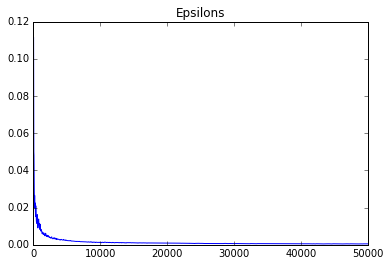

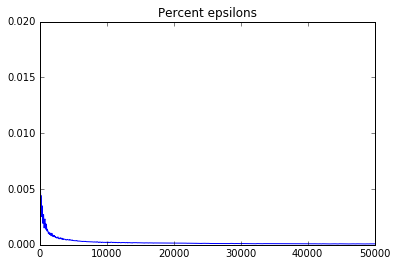

File = 1556571206_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 15086.026660442352 seconds (aka 4.1905629612339865 hours)
Average duration of batch = 6.034410664176941 seconds (aka 0.0016762251844935948 hours)
Solved in 15179.589269399643 seconds
Solved in 252.99315448999405 minutes
Solved in 4.216552574833234 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.29389676575732


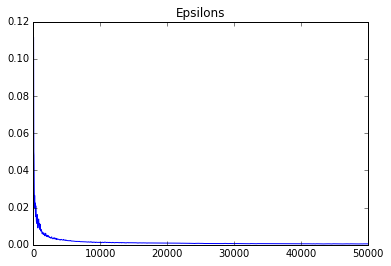

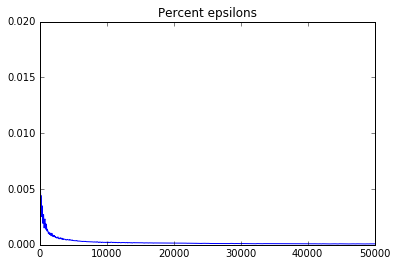

File = 1556571137_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 14475.65656042099 seconds (aka 4.021015711228053 hours)
Average duration of batch = 5.790262624168396 seconds (aka 0.001608406284491221 hours)
Solved in 14568.541101694107 seconds
Solved in 242.80901836156846 minutes
Solved in 4.046816972692808 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.4320526434994743


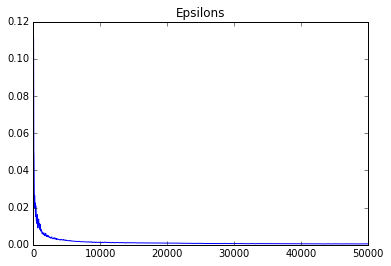

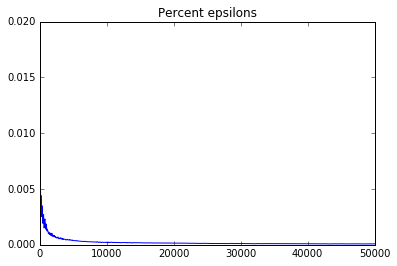

File = 1556571188_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 14629.60904121399 seconds (aka 4.063780289226108 hours)
Average duration of batch = 5.851843616485596 seconds (aka 0.0016255121156904433 hours)
Solved in 14721.197874546051 seconds
Solved in 245.35329790910086 minutes
Solved in 4.089221631818347 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.3964627353086114


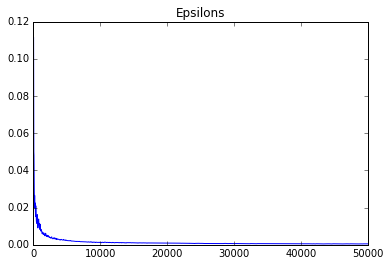

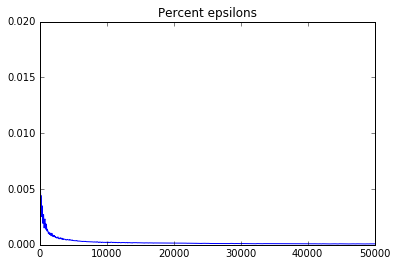

File = 1556571199_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 14688.581914186478 seconds (aka 4.0801616428295775 hours)
Average duration of batch = 5.875432765674591 seconds (aka 0.0016320646571318308 hours)
Solved in 14783.258353948593 seconds
Solved in 246.38763923247654 minutes
Solved in 4.106460653874609 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.3822043018442582


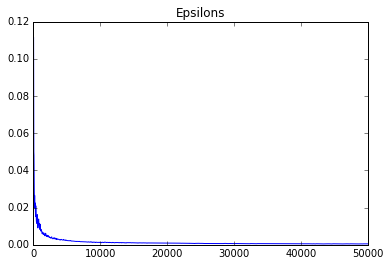

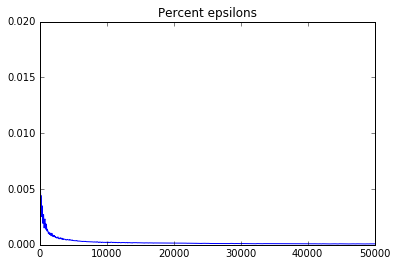

File = 1556571159_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 14020.349813222885 seconds (aka 3.894541614784135 hours)
Average duration of batch = 5.608139925289154 seconds (aka 0.001557816645913654 hours)
Solved in 14116.58747267723 seconds
Solved in 235.27645787795385 minutes
Solved in 3.9212742979658977 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.5419325029349626


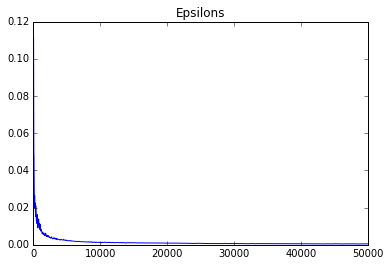

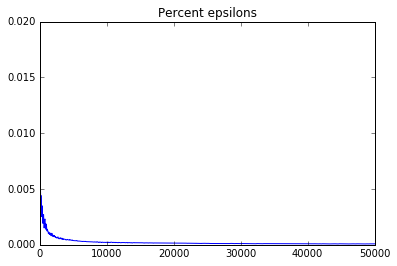

File = 1556571212_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 13946.212455749512 seconds (aka 3.8739479043748646 hours)
Average duration of batch = 5.578484982299805 seconds (aka 0.0015495791617499456 hours)
Solved in 14038.498877286911 seconds
Solved in 233.97498128811517 minutes
Solved in 3.8995830214685863 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.5616343625525175


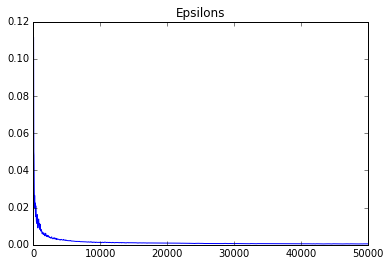

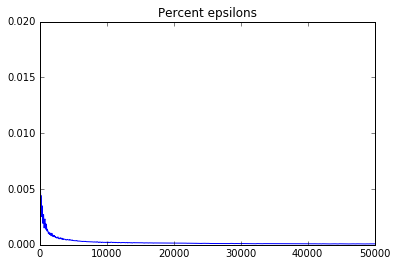

File = 1556571193_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 15142.535593271255 seconds (aka 4.206259887019793 hours)
Average duration of batch = 6.057014237308502 seconds (aka 0.0016825039548079173 hours)
Solved in 15237.947667598724 seconds
Solved in 253.96579445997875 minutes
Solved in 4.232763240999645 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.281281776962505


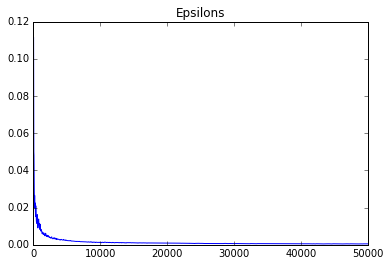

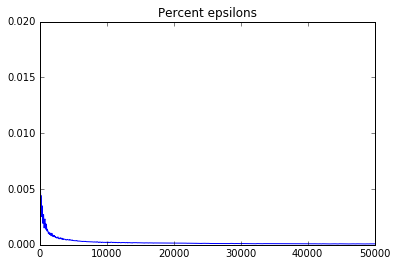

File = 1556571143_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 14702.407687425613 seconds (aka 4.084002135396004 hours)
Average duration of batch = 5.8809630749702455 seconds (aka 0.0016336008541584016 hours)
Solved in 14798.696454524994 seconds
Solved in 246.6449409087499 minutes
Solved in 4.1107490151458315 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.378675963362402


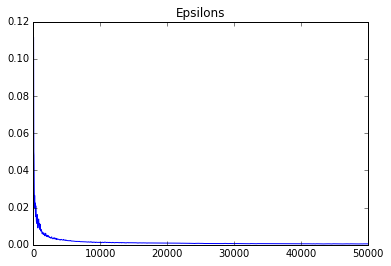

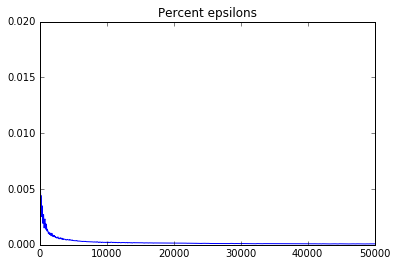

File = 1556571154_3_5
Game = kuhn_3_5
Total iterations = 50000
Check every iteration = 20
Logged 2500 out of 2500.0 datapoints in 14481.12450003624 seconds (aka 4.0225345833434 hours)
Average duration of batch = 5.792449800014496 seconds (aka 0.00160901383333736 hours)
Solved in 14574.923192501068 seconds
Solved in 242.91538654168446 minutes
Solved in 4.048589775694741 hours
Final utility = [-0.03469373683824155, 0.0128829694491404, 0.021810767389101145]
Social welfare = -3.469446951953614e-18
Average iterations per second = 3.4305498107685026


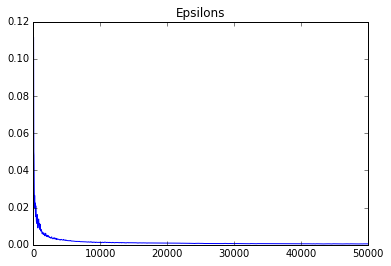

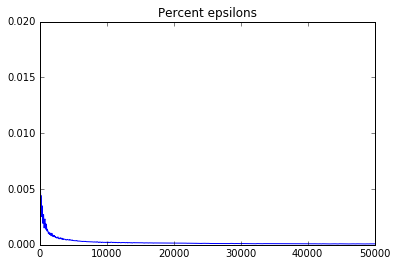

In [49]:
target_epsilons = [0.1, 0.01, 0.001, 0.0001, 0.00001]
data_per_instance = {}

for name in file_names:
    analyze(name, target_epsilons, data_per_instance)
    
# Average if needed
new_data_per_instance = {}
for (s, data) in data_per_instance.items():
    if type(data) != list:
        new_data_per_instance[s] = data
    elif len(data) > 1:
        tot_time = [0 for _ in target_epsilons]
        tot_it = [0 for _ in target_epsilons]
        for d in data:
            for i in range(len(target_epsilons)):
                tot_time[i] += d['time_to_target'][i]
                tot_it[i] += d['iterations_to_target'][i]
        for i in range(len(target_epsilons)):
            tot_time[i] /= len(data)
            tot_it[i] /= len(data)
        new_data_per_instance[s] = {'time_to_target': tot_time,
                                    'iterations_to_target': tot_it,
                                    'parameters': data[0]['parameters']}
    
data_per_instance = new_data_per_instance

In [50]:
size_data = {
    'kuhn_3_6': (72, 147),
    'kuhn_3_7': (84, 171),
    'kuhn_3_8': (96, 195),
    'kuhn_3_9': (108, 219),
    'kuhn_3_10': (120, 243),
    
    'leduc_3_3_3': (684, 1371),
    'leduc_3_3_4': (1200, 2403),
    'leduc_3_3_5': (1860, 3723),
    'leduc_3_3_6': (2664, 5331),
    'leduc_3_3_7': (3612, 7227),
    'leduc_3_3_8': (4704, 9411),
    
    'goofspiel_3_3_accumulate': (194, 396),
    'goofspiel_3_3_discard_if_all': (194, 396),
    'goofspiel_3_3_discard_if_high': (194, 396),
    'goofspiel_3_3_discard_always': (194, 396),
    'goofspiel_3_4_accumulate': (48966, 98523),
    'goofspiel_3_4_discard_if_all': (48966, 98523),
    'goofspiel_3_4_discard_if_high': (48966, 98523),
    'goofspiel_3_4_discard_always': (48966, 98523),
    
    # Random sized are taken from specific dat files
    'random_2_5_2': (24, 46),
    'random_2_6_2': (52, 102),
    'random_2_7_2': (94, 186),
    'random_2_8_2': (186, 370),
    'random_2_9_2': (383, 764),
    'random_2_10_2': (776, 1550),
    'random_3_5_2': (29, 55),
    'random_3_6_2': (49, 95),
    'random_3_7_2': (100, 197),
    'random_3_8_2': (206, 409),
    'random_3_9_2': (378, 753),
    'random_3_10_2': (757, 1541),
}

In [51]:
def count_sequences(cfr_tree):
    all_nodes = reduce(lambda x, y: x + y.nodes, cfr_tree.information_sets.values(), [])
    all_leaves = list(filter(lambda n: n.isLeaf(), reduce(lambda x, y: x + y.children, all_nodes, [])))
    all_nodes = all_nodes + all_leaves
    
    count = 0

    for p in range(cfr_tree.numOfPlayers):
        Q_raw = list(filter(lambda q: q != {}, map(lambda n: n.base_node.getSequence(p), all_nodes)))
        Q = [{}] + [dict(t) for t in {tuple(d.items()) for d in Q_raw}]
        count += len(Q)
        
    return count

def count_infosets(cfr_tree):
    return len(cfr_tree.information_sets)

def get_size_data(par):
    name = parameters_to_string(par)
    if name not in size_data:
        if par['game'] == 'kuhn':
            cfr_tree = CFRTree(build_kuhn_tree(par['players'], par['rank']))
        elif par['game'] == 'leduc':
            cfr_tree = CFRTree(build_leduc_tree(par['players'], par['suits'], par['rank'], 
                                                par['betting_parameters']))
        elif par['game'] == 'goofspiel':
            # Tie solver is not needed to determine the size of the game
            cfr_tree = CFRTree(build_goofspiel_tree(par['players'], par['rank']))
        size_data[name] = (count_infosets(cfr_tree), count_sequences(cfr_tree))
        
    return size_data[name]

In [52]:
from IPython.display import HTML, display
import tabulate

In [53]:
table_text = [['Game', 'Inf.', 'Seq.', 'Delta'] + (list(map(lambda el: str(el) + '%', target_epsilons)))]
for (game, data) in sorted(data_per_instance.items()):
    par = data['parameters']
    
    size = get_size_data(par)
    
    line_text = [game, size[0], size[1]]
    line_text.append(delta_utility(par['game'], par['players'], par['rank'], par['betting_parameters']))
    line_text += list(map(lambda t: 'n/a' if t == -1 else str(t), data['time_to_target']))
    
    table_text.append(line_text)
    
    print(game + " done")

kuhn_3_5 done
kuhn_3_5_ done
kuhn_3_5__ done
kuhn_3_5___ done
kuhn_3_5____ done
kuhn_3_5_____ done
kuhn_3_5______ done
kuhn_3_5_______ done
kuhn_3_5________ done
kuhn_3_5_________ done
kuhn_3_5_average done


In [54]:
display(HTML(tabulate.tabulate(table_text, tablefmt='html')))

Game,Inf.,Seq.,Delta,0.1%,0.01%,0.001%,0.0001%,1e-05%
kuhn_3_5,60,123,6,0.53581,1.69557,86.84386,8417.02746,n/a
kuhn_3_5_,60,123,6,0.49513,1.5817,86.74697,8556.13384,n/a
kuhn_3_5__,60,123,6,0.50299,1.60558,85.90345,8195.66668,n/a
kuhn_3_5___,60,123,6,0.46344,1.47437,83.88319,8275.03435,n/a
kuhn_3_5____,60,123,6,0.48344,1.51559,83.79027,8312.38025,n/a
kuhn_3_5_____,60,123,6,0.52113,1.67604,83.21023,7931.35881,n/a
kuhn_3_5______,60,123,6,0.48235,1.55748,85.52368,7966.50593,n/a
kuhn_3_5_______,60,123,6,0.49132,1.60434,86.86475,8569.44546,n/a
kuhn_3_5________,60,123,6,0.51066,1.63461,86.21523,8334.5817,n/a
kuhn_3_5_________,60,123,6,0.50918,1.61135,83.82415,8200.66281,n/a


In [ ]:
display(HTML(tabulate.tabulate(table_text, tablefmt='html')))

### Table for number of iterations instead of running time

In [ ]:
table_text2 = [['Targets'] + (list(map(str, target_epsilons)))]
for (game, data) in sorted(data_per_instance.items()):
    line_text = [game] + list(map(lambda t: 'n/a' if t == -1 else str(t), data['iterations_to_target']))
    table_text2.append(line_text)

In [ ]:
display(HTML(tabulate.tabulate(table_text2, tablefmt='html')))

## Time comparisons

In [ ]:
def compare(files, xlims_time = None, xlims_iter = None, ylims = None, legend = None, title = 'Comparison'):
    fig_time, ax_time = plt.subplots()
    fig_iter, ax_iter = plt.subplots()
    
    for filename in files:
        file = open(filename, "r")
        data = json.load(file)
        file.close()

        print("File = " + filename)
        print("Game = " + parameters_to_string(data['parameters']))

        print("Total iterations = " + str(data['parameters']['number_iterations']))
        print("Check every iteration = " + str(data['parameters']['check_every_iteration']))

        durations = list(map(lambda el: el['duration'], data['data']))

        du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
                   data['parameters']['betting_parameters'], data['parameters']['color_distribution'], 
                   data['parameters']['suits'])

        iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
        epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
        percent_epsilons = list(map(lambda el: el / du, epsilons))
        cum_durations = [sum(durations[:i]) for i in range(len(durations))]
        
        ax_time.plot(cum_durations, percent_epsilons)
        ax_iter.plot(iteration_counts, percent_epsilons)
        
    if legend == None:
        legend = ["Result " + str(i+1) for i in range(len(files))]
    ax_time.legend(legend)
    ax_iter.legend(legend)
    ax_time.set(xlabel = "Time [s]", ylabel = "Epsilon [%]")
    ax_iter.set(xlabel = "Iterations", ylabel = "Epsilon [%]")
    if ylims != None:
        ax_time.set_ylim(ylims)
        ax_iter.set_ylim(ylims)
    if xlims_time != None:
        ax_time.set_xlim(xlims_time)
    if xlims_iter != None:
        ax_iter.set_xlim(xlims_iter)
    ax_time.set_title(title)
    ax_iter.set_title(title)

In [ ]:
compare(['results/remote/RCFR/kuhn/1553957872_3_8', 'results/remote/kuhn_20190120/1547765102_3_8'],
        xlims = (0, 15000), ylims = (0, 0.02), legend = ['RCFR', 'SCFR'], title = 'Kuhn 3_8')
compare(['results/remote/RCFR/kuhn/1553957872_3_8', 'results/remote/kuhn_short_20190121/1548008650_3_8'],
        xlims = (0, 15000), ylims = (0, 0.02), legend = ['RCFR', 'SCFR'], title = 'Kuhn 3_8')
compare(['results/remote/RCFR/kuhn/1553957868_3_7', 'results/remote/kuhn_20190120/1547765096_3_7'],
        xlims = (0, 7000), ylims = (0, 0.02), legend = ['RCFR', 'SCFR'], title = 'Kuhn 3_7')

In [ ]:
compare(['results/remote/RCFR/kuhn/1553957883_3_10', 'results/remote/RCFR_notopt/kuhn/1554108461_3_10'],
        xlims = (0, 10000), legend = ['RCFR', 'RCFR_nopt'], title = 'Kuhn 3_10')

In [ ]:
compare(['results/remote/RCFR/kuhn/1553957872_3_8', 'results/remote/RCFR_notopt/kuhn/1554108461_3_8',
         'results/remote/kuhn_20190120/1547765102_3_8'],
        xlims = (0, 5000), legend = ['RCFR', 'RCFR_nopt', 'SCFR'], title = 'Kuhn 3_8')
compare(['results/remote/RCFR/kuhn/1553957872_3_8', 'results/remote/RCFR_notopt/kuhn/1554108461_3_8',
         'results/remote/kuhn_20190120/1547765102_3_8'],
        xlims = (0, 1000), ylims = (0, 0.05), legend = ['RCFR', 'RCFR_nopt', 'SCFR'], title = 'Kuhn 3_8')

In [ ]:
compare(['results/remote/RCFR_notopt/goofspiel/1554199851_3_4', 
         'results/remote/goofspiel_long_20180122/1548105218_3_4'], legend = ["RCFR_nopt", "SCFR"],
         title = "Goofspiel 3_4")

compare(['results/remote/RCFR_notopt/goofspiel/1554382206_3_4', 
         'results/remote/goofspiel_long_20180122/1548105218_3_4'], legend = ["RCFR_nopt", "SCFR"],
         title = "Goofspiel 3_4")

In [ ]:
compare(['results/remote/RCFR_notopt/hanabi/1554413019_2_2_[2_1]_1_1', 
         'results/remote/SCFR_hanabi/hanabi/1554461737_2_2_[2_1]_1_1'], legend = ["RCFR_nopt", "SCFR"],
         title = "Hanabi 2 colors [2, 1] distribution")

In [ ]:
compare(['results/remote/hanabi_tests/RCFR_nopt/hanabi/1554739324_3_1_[2_2_1]_1_1',
         'results/remote/hanabi_tests/SCFR/hanabi/1554739324_3_1_[2_2_1]_1_1'], ylims = (0, 0.02), 
        legend = ["RCFR", "SCFR"])

In [ ]:
compare(['results/remote/hanabi_tests/RCFR/hanabi/1554830690_2_1_[2_2_1]_1_1',
         'results/remote/hanabi_tests/RCFR_nopt/hanabi/1554830690_2_1_[2_2_1]_1_1',
         'results/remote/hanabi_tests/SCFR/hanabi/1554830690_2_1_[2_2_1]_1_1'], 
         legend = ["RCFR", "RCFR_nopt", "SCFR"], xlims = (0, 10000), ylims = (0, 0.05))

In [ ]:
compare(['results/remote/hanabi_tests/SCFR/hanabi/1554741241_3_2_[2_1]_1_1',
         'results/remote/hanabi_tests/RCFR_nopt/hanabi/1554741154_3_2_[2_1]_1_1'], 
         legend = ["SCFR", "RCFR_nopt"])

In [ ]:
compare(['results/remote/hanabi_tests/RCFR_nopt/hanabi/1554831012_2_2_[2_1]_1_1',
         'results/remote/hanabi_tests/SCFR/hanabi/1554831004_2_2_[2_1]_1_1'], ylims = (0, 0.2), 
        legend = ["RCFR_nopt", "SCFR"])

---

## SCFR/CFR/CFR+ comparisons

In [ ]:
import numpy as np

In [ ]:
def compare_algorithms(filename, filename_cfr, filename_cfr_plus, cumsum_durations = False):
    file = open(filename, "r")
    data = json.load(file)
    file.close()

    file_cfr = open(filename_cfr, "r")
    data_cfr = json.load(file_cfr)
    file_cfr.close()

    file_cfr_plus = open(filename_cfr_plus, "r")
    data_cfr_plus = json.load(file_cfr_plus)
    file_cfr_plus.close()    

    durations = list(map(lambda el: el['duration'], data['data']))
    durations_cfr = list(map(lambda el: el['duration'], data_cfr['data']))
    durations_cfr_plus = list(map(lambda el: el['duration'], data_cfr_plus['data']))

    du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
                   data['parameters']['betting_parameters'])
    du_cfr = delta_utility(data_cfr['parameters']['game'], data_cfr['parameters']['players'], 
                           data_cfr['parameters']['rank'], data_cfr['parameters']['betting_parameters'])
    du_cfr_plus = delta_utility(data_cfr_plus['parameters']['game'], data_cfr_plus['parameters']['players'], 
                           data_cfr_plus['parameters']['rank'], data_cfr_plus['parameters']['betting_parameters'])

    iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
    epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
    percent_epsilons = list(map(lambda el: el / du, epsilons))
    iteration_counts_cfr = list(map(lambda el: el['iteration_number'], data_cfr['data']))
    epsilons_cfr = list(map(lambda el: max(0, -min(el['epsilon'])), data_cfr['data']))
    percent_epsilons_cfr = list(map(lambda el: el / du_cfr, epsilons_cfr))
    iteration_counts_cfr_plus = list(map(lambda el: el['iteration_number'], data_cfr_plus['data']))
    epsilons_cfr_plus = list(map(lambda el: max(0, -min(el['epsilon'])), data_cfr_plus['data']))
    percent_epsilons_cfr_plus = list(map(lambda el: el / du_cfr_plus, epsilons_cfr_plus))
    utilities = list(map(lambda el: el['utility'], data['data']))
    utilities_cfr = list(map(lambda el: el['utility'], data_cfr['data']))
    utilities_cfr_plus = list(map(lambda el: el['utility'], data_cfr_plus['data']))

    print(data['parameters'])
    if 'total_duration' in data:
        print("Duration = " + str(data['total_duration']) + " seconds")
        print("Utility = " + str(data['utility']))
        print("Social welfare = " + str(sum(data['utility'])))
        print("Max delta utility = " + str(max(data['utility']) - min(data['utility'])))
    else:
        print("--- Computation was stopped before the end ---")
        print("Duration = " + str(sum(durations)) + " seconds")
        print("Last logged utility = " + str(utilities[len(utilities)-1]))
        print("Social welfare = " + str(sum(utilities[len(utilities)-1])))
        print("Max delta utility = " + str(max(utilities[len(utilities)-1]) - min(utilities[len(utilities)-1])))
    print('')
    print(data_cfr['parameters'])
    if 'total_duration' in data_cfr:
        print("Duration = " + str(data_cfr['total_duration']) + " seconds")
        print("Utility = " + str(data_cfr['utility']))
        print("Social welfare = " + str(sum(data_cfr['utility'])))
        print("Max delta utility = " + str(max(data_cfr['utility']) - min(data_cfr['utility'])))
    else:
        print("--- Computation was stopped before the end ---")
        print("Duration = " + str(sum(durations_cfr)) + " seconds")
        print("Last logged utility = " + str(utilities_cfr[len(utilities_cfr)-1]))
        print("Social welfare = " + str(sum(utilities_cfr[len(utilities_cfr)-1])))
        print("Max delta utility = " + str(max(utilities_cfr[len(utilities_cfr)-1]) - \
                                           min(utilities_cfr[len(utilities_cfr)-1])))
    print('')
    print(data_cfr_plus['parameters'])
    if 'total_duration' in data_cfr_plus:
        print("Duration = " + str(data_cfr_plus['total_duration']) + " seconds")
        print("Utility = " + str(data_cfr_plus['utility']))
        print("Social welfare = " + str(sum(data_cfr_plus['utility'])))
        print("Max delta utility = " + str(max(data_cfr_plus['utility']) - min(data_cfr_plus['utility'])))
    else:
        print("--- Computation was stopped before the end ---")
        print("Duration = " + str(sum(durations_cfr_plus)) + " seconds")
        print("Last logged utility = " + str(utilities_cfr_plus[len(utilities_cfr_plus)-1]))
        print("Social welfare = " + str(sum(utilities_cfr_plus[len(utilities_cfr_plus)-1])))
        print("Max delta utility = " + str(max(utilities_cfr_plus[len(utilities_cfr_plus)-1]) - \
                                           min(utilities_cfr_plus[len(utilities_cfr_plus)-1])))
    print('')

    #plt.plot(iteration_counts, epsilons)
    #plt.plot(iteration_counts_cfr, epsilons_cfr)
    #plt.plot(iteration_counts_cfr_plus, epsilons_cfr_plus)
    #plt.show()
    
    plt.plot(iteration_counts, percent_epsilons)
    plt.plot(iteration_counts_cfr, percent_epsilons_cfr)
    plt.plot(iteration_counts_cfr_plus, percent_epsilons_cfr_plus)
    plt.legend(['scfr','cfr', 'cfr+'])
    plt.show()
    
    plt.plot(np.cumsum(durations), percent_epsilons)
    plt.plot(np.cumsum(durations_cfr) if cumsum_durations else durations_cfr, percent_epsilons_cfr)
    plt.plot(np.cumsum(durations_cfr_plus) if cumsum_durations else durations_cfr_plus, percent_epsilons_cfr_plus)
    plt.legend(['scfr','cfr', 'cfr+'])
    plt.show()

In [ ]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_scfr_accumulate',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_accumulate',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_accumulate')

In [ ]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_scfr_accumulate',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_accumulate',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_plus_accumulate',
                   cumsum_durations = True)

In [ ]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_scfr_discard_if_all',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_discard_if_all', 
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_plus_discard_if_all',
                   cumsum_durations = True)

In [ ]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_scfr_discard_if_high',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_discard_if_high',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_plus_discard_if_high',
                   cumsum_durations = True)

In [ ]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_scfr_discard_always',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_discard_always',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_plus_discard_always',
                   cumsum_durations = True)

In [ ]:
compare_algorithms('results/remote/goofspiel_long_20180122/1548105233_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_always_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_always_ALBO',
                   cumsum_durations = True)

In [ ]:
compare_algorithms('results/remote/goofspiel_long_20180122/1548105230_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_if_high_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_if_high_ALBO',
                   cumsum_durations = True)

In [ ]:
compare_algorithms('results/remote/goofspiel_long_20180122/1548105224_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_if_all_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_if_all_ALBO',
                   cumsum_durations = True)

## Data to CSV for tikz

In [ ]:
f1 = open('results/remote/goofspiel_long_20180122/1548105233_3_4', 'r')
f2 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_always_ALBO', 'r')
f3 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_always_ALBO', 'r')

f4 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_scfr_accumulate', 'r')
f5 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_accumulate', 'r')
f6 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_accumulate', 'r')

data1 = json.load(f1)
data2 = json.load(f2)
data3 = json.load(f3)

data4 = json.load(f4)
data5 = json.load(f5)
data6 = json.load(f6)

durations1 = list(map(lambda el: el['duration'], data1['data']))
durations2 = list(map(lambda el: el['duration'], data2['data']))
durations3 = list(map(lambda el: el['duration'], data3['data']))

durations4 = list(map(lambda el: el['duration'], data4['data']))
durations5 = list(map(lambda el: el['duration'], data5['data']))
durations6 = list(map(lambda el: el['duration'], data6['data']))

du = delta_utility('goofspiel', 3, 4)

with open("cfr_comparison_3_4_discard_always_scfr.csv", 'w') as o:
    o.write('iteration, epsilon, t\n')
    
    for i in range(len(data1['data'])):
        d = data1['data'][i]
        o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon']) / du) + ', ' + \
                str(sum(durations1[:i+1])) + "\n")
        
with open("cfr_comparison_3_4_discard_always_cfr.csv", 'w') as o:
    o.write('iteration, epsilon, t\n')
    
    for i in range(len(data2['data'])):
        d = data2['data'][i]
        o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon']) / du) + ', ' + \
                str(sum(durations2[:i+1])) + "\n")
        
with open("cfr_comparison_3_4_discard_always_cfr_plus.csv", 'w') as o:
    o.write('iteration, epsilon, t\n')
    
    for i in range(len(data3['data'])):
        d = data3['data'][i]
        o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon']) / du) + ', ' + \
                str(sum(durations3[:i+1])) + "\n")

with open("cfr_comparison_3_4_accumulate.csv", 'w') as o:
    o.write('iteration, scfr, cfr, cfr+\n')
    
    iterations = list(map(lambda el: el['iteration_number'], data4['data']))
    epsilons4 = list(map(lambda el: -min(el['epsilon']) / du, data4['data']))
    epsilons5 = list(map(lambda el: -min(el['epsilon']) / du, data5['data']))
    epsilons6 = list(map(lambda el: -min(el['epsilon']) / du, data6['data']))
    
    for (it, s, c, cp) in zip(iterations, epsilons4, epsilons5, epsilons6):
        o.write(str(it) + ', ' + str(s) + ', ' + str(c) + ', ' + str(cp) + '\n')
        
f1.close()
f2.close()
f3.close()

f4.close()
f5.close()
f6.close()

In [ ]:
icml_data_folder  = "../../../../Dropbox/Honours Programme/Shared Material/ICML-19/imgs/data/"

In [ ]:
def print_csv(name1, name2, name3):
    f1 = open(name1, 'r')
    f2 = open(name2, 'r')
    f3 = open(name3, 'r')

    data1 = json.load(f1)
    data2 = json.load(f2)
    data3 = json.load(f3)

    durations1 = list(map(lambda el: el['duration'], data1['data']))
    durations2 = list(map(lambda el: el['duration'], data2['data']))
    durations3 = list(map(lambda el: el['duration'], data3['data']))

    du = delta_utility('goofspiel', 3, 4)

    shortest_run = min(sum(durations1), sum(durations2), sum(durations3))
    
    ts = data1['parameters']['tie_solver']

    with open(icml_data_folder + "cfr_comparison_3_4_" + ts + "_scfr.csv", 'w') as o:
        o.write('iteration, epsilon, t\n')

        for i in range(len(data1['data'])):
            if sum(durations1[:i+1]) > shortest_run:
                break

            d = data1['data'][i]
            o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon'] + [0]) / du) + ', ' + \
                    str(sum(durations1[:i+1])) + "\n")

    with open(icml_data_folder + "cfr_comparison_3_4_" + ts + "_cfr.csv", 'w') as o:
        o.write('iteration, epsilon, t\n')

        for i in range(len(data2['data'])):
            if sum(durations2[:i+1]) > shortest_run:
                break

            d = data2['data'][i]
            o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon'] + [0]) / du) + ', ' + \
                    str(sum(durations2[:i+1])) + "\n")

    with open(icml_data_folder + "cfr_comparison_3_4_" + ts + "_cfr_plus.csv", 'w') as o:
        o.write('iteration, epsilon, t\n')

        for i in range(len(data3['data'])):
            if sum(durations3[:i+1]) > shortest_run:
                break

            d = data3['data'][i]
            o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon'] + [0]) / du) + ', ' + \
                    str(sum(durations3[:i+1])) + "\n")

    f1.close()
    f2.close()
    f3.close()

In [ ]:
print_csv('results/remote/goofspiel_long_20180122/1548105233_3_4',
          'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_always_ALBO',
          'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_always_ALBO')

In [ ]:
print_csv('results/remote/goofspiel_long_20180122/1548105230_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_if_high_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_if_high_ALBO')

In [ ]:
print_csv('results/remote/goofspiel_long_20180122/1548105224_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_if_all_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_if_all_ALBO')